# LIF Ensemble

## Import dependencies

In [74]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [75]:
from sapicore.engine.ensemble.spiking import LIFEnsemble
from sapicore.utils.plotting import spike_raster 

In [76]:
# Uncomment the following line if sapinet is not already installed in your current environment
# %pip install git+https://github.com/cplab/sapinet2.git

## Define experiment specific variables

In [77]:
steps = 200

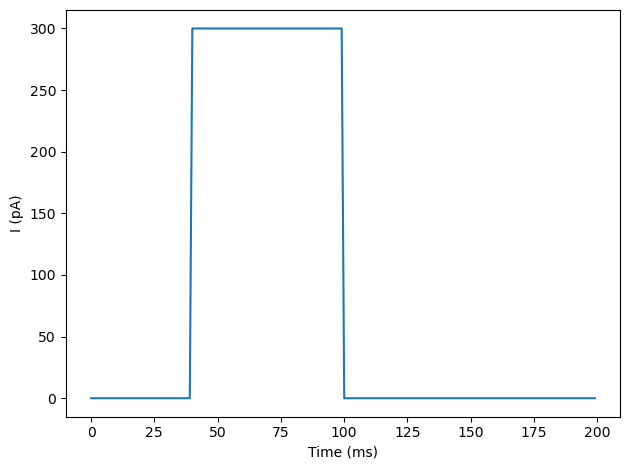

In [78]:
I = torch.ones(steps) * 300
I[int(steps/2):] = 0
I[:int(steps/5)] = 0

plt.subplots(1)
plt.plot(range(steps), I)
plt.xlabel('Time (ms)')
plt.ylabel('I (pA)')
plt.tight_layout()
plt.show()

## Let's create an ensemble of 10 neurons

In [79]:
spiking_ensemble = LIFEnsemble(num_units = 10)

In [80]:
output = [spiking_ensemble.forward(I[i]) for i in range(steps)]
print(output[0])

{'input': tensor([0.]), 'voltage': tensor([-75.]), 'spiked': tensor([0], dtype=torch.int32)}


## Plotting membrane voltage

In [81]:
volt_mem = [output[i].get('voltage') for i in range(steps)]
volt_mem = torch.stack(volt_mem)
volt_mem.shape

torch.Size([200, 1])

In [82]:
### Let's turn our Tutorial 1 plot of the voltage membrane into its own function for ease of use
def plot_voltage(voltage_data, simulation_steps):
    plt.subplots()
    plt.plot(range(simulation_steps), voltage_data)
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.tight_layout()
    plt.show()


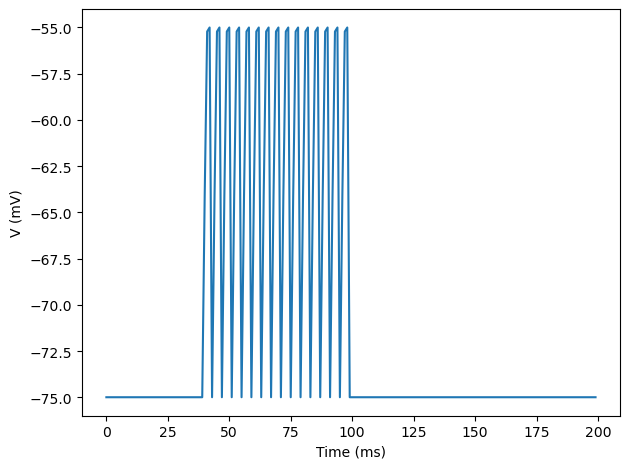

In [83]:
plot_voltage(volt_mem, steps)

In [84]:
spikes = [output[i].get('spiked') for i in range(steps)]
spikes = torch.stack(spikes)
spikes.shape

torch.Size([200, 1])

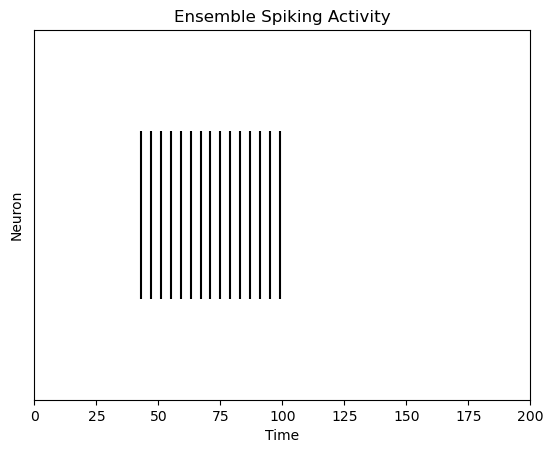

In [85]:
spike_raster(spikes)

## Now let's customize the synapses and synaptic weights in that ensemble

In [86]:
from sapicore.engine.synapse import Synapse

We define a `SingleEnsemble` class that contains a `LIFEnsemble` of 10 neurons and we customize the synaptic connection matrix and synaptic weight matrix of this ensemble. In this case the synaptic connections are static and do not change with time.

In [87]:
steps = 200

In [88]:
I = torch.ones(steps) * 200
I[int(steps/2):] = 0
I[:int(steps/5)] = 0

In [89]:
class SingleEnsemble(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.simulation_step = 0

        #Define the LIF Ensemble object
        self.ensemble = LIFEnsemble(num_units=10, leak_gl=5, tau_mem=5, tau_ref=1)
        # Define the Synapse object
        self.synapse = Synapse(src_ensemble=self.ensemble, dst_ensemble=self.ensemble,
                                 weight_min=0, weight_max=100)
        # Customise connections with randomly generated connections between neurons
        self.synapse.connections = torch.randint(0, 2, (10, 10))
        # Customize synaptic weights with randomly generated weights
        self.synapse.weights = torch.rand(10, 10) * 100
        
    def forward(self, x: torch.Tensor):
        # after the first iteration, the input to the ensemble must include the incoming synapses' output as well.
        synapse_output = self.synapse(self.ensemble.spiked.float())
        ensemble_output = self.ensemble(x + (self.synapse.output if self.simulation_step > 0 else 0))
        self.simulation_step += 1
        return ensemble_output, synapse_output

single_ensemble = SingleEnsemble()

We plot the connectivity matrix

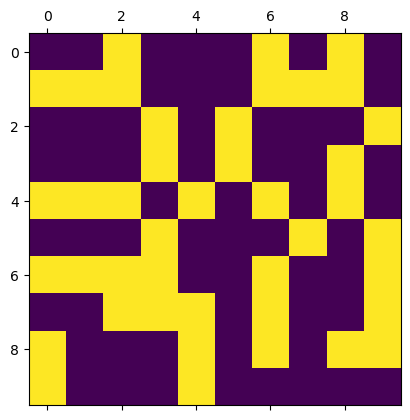

In [90]:
plt.matshow(single_ensemble.synapse.connections)

And the weight matrix

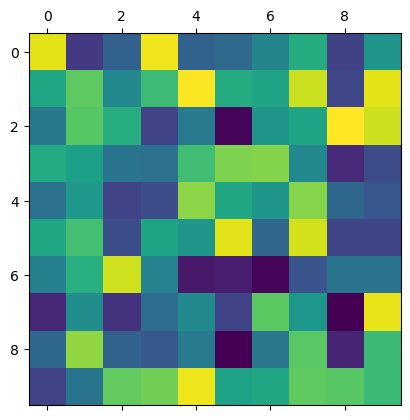

In [91]:
plt.matshow(single_ensemble.synapse.weights)

In [92]:
output2 = [single_ensemble.forward(I[i]) for i in range(steps)]
print(output2[0])

({'input': tensor([0.]), 'voltage': tensor([-75., -75., -75., -75., -75., -75., -75., -75., -75., -75.]), 'spiked': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)}, {'weights': tensor([[ 0.0000,  0.0000, 31.2027,  0.0000,  0.0000,  0.0000, 45.2571,  0.0000,
         20.0140,  0.0000],
        [59.2118, 74.4055, 46.7301,  0.0000,  0.0000,  0.0000, 57.9597, 91.0385,
         21.7797,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 20.6797,  0.0000,  2.2224,  0.0000,  0.0000,
          0.0000, 91.2703],
        [ 0.0000,  0.0000,  0.0000, 37.7589,  0.0000, 80.0467,  0.0000,  0.0000,
         12.5054,  0.0000],
        [37.3260, 53.8910, 20.9710,  0.0000, 81.6650,  0.0000, 52.6016,  0.0000,
         33.7260,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 58.0115,  0.0000,  0.0000,  0.0000, 92.0685,
          0.0000, 21.1373],
        [43.3790, 62.3549, 91.6612, 44.3025,  0.0000,  0.0000,  2.3720,  0.0000,
          0.0000, 38.6980],
        [ 0.0000,  0.0000, 15.0399, 35.8372, 47.3

In [93]:
volt_mem2 = [output2[i][0].get('voltage') for i in range(steps)]
volt_mem2 = torch.stack(volt_mem2)
volt_mem2.shape

torch.Size([200, 10])

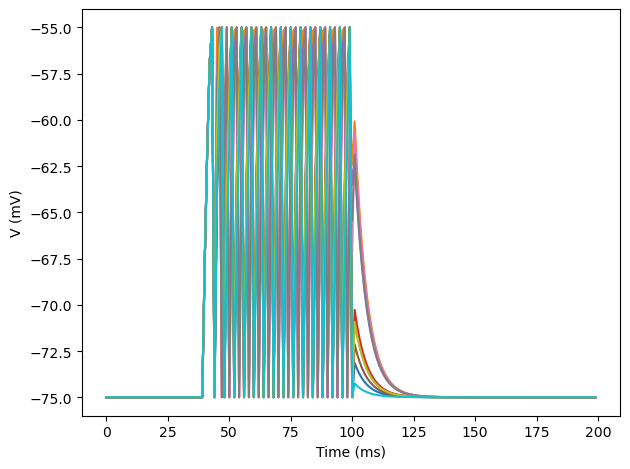

In [94]:
plot_voltage(volt_mem2, steps)

In [95]:
spikes2 = [output2[i][0].get('spiked') for i in range(steps)]
spikes2 = torch.stack(spikes2)
spikes2.shape

torch.Size([200, 10])

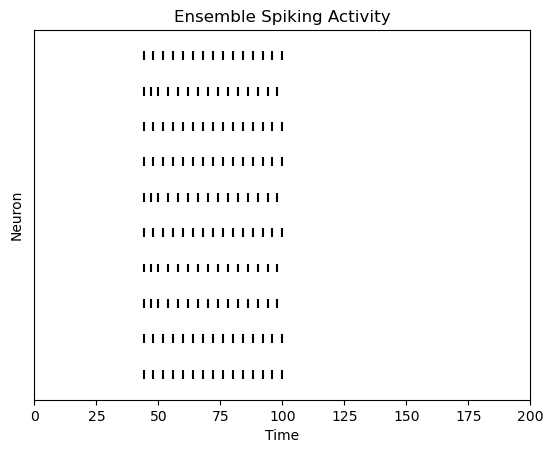

In [96]:
spike_raster(spikes2)